In [51]:
import requests
import json
import pandas as pd
from datetime import date
import pyodbc
import logging


In [52]:
#Define Variables

api_key = '28f960e7da1f4ef2b960e7da1f4ef243' #API Key from Weather Underground Personal Weather Station(PWS)
driver  = '{SQL Server}' #Driver
server  = 'DESKTOP-BMEMTUQ\SQLEXPRESS' #SQL Server name to post to
database= 'PWS' #SQL database
db_table= 'PWS.dbo.RAW_PWSdata' #SQL Table within above database
resp_date_df = pd.DataFrame() #initialize dataframe to be inserted in db_table
#Column names for pandas data frame
column_names = ['Station_ID','Timezone','Timestamp_UTC', 'Timestamp_Local', 'epoch', 'Lat', 'Lon', 'solarRadiationHigh','uvHigh', 'WindDir_Avg', 'Humidity_High','Humidity_Low','Humidity_Avg','qcStatus', 'Temp_High','Temp_Low','Temp_Avg','WindSpeed_High','WindSpeed_Low','WindSpeed_Avg','WindGust_High','WindGust_Low','WindGust_Avg','DewPt_High','DewPt_Low','DewPt_Avg','WindChill_High','WindChill_Low','WindChill_Avg','HeatIndex_High','HeatIndex_Low','HeatIndex_Avg','Pressure_Max','Pressure_Min', 'PressureTrend','PrecipRate','PrecipTotal']


In [53]:
#Create and configure logger

logging.basicConfig(level = logging.DEBUG, filename='C:/Users/okiem/appendPWS.log', filemode='a', format='%(asctime)s - %(levelname)s - %(message)s')

In [68]:
#Perform GET request on WeatherUnderground API from key for historical date

date = 20200911  #Enter date to pull data YYYYMMDD
url_date = f'https://api.weather.com/v2/pws/history/hourly?stationId=KOKEDMON233&format=json&units=e&numericPrecision=decimal&date={date}&apiKey={api_key}'
#url_date = f'https://api.weather.com/v2/pws/observations/all/1day?stationId=KOKEDMON233&format=json&units=e&numericPrecision=decimal&apiKey={api_key}'

resp_date = requests.get(url_date) #Perform GET request
logging.info(f'url_date GET request status code: {resp_date.status_code}')

In [69]:
#Connect to SQL Sever

conn = pyodbc.connect(f'Driver={driver};'
                      f'Server={server};'
                      f'Database={database};'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

In [70]:
#Create raw Pandas DataFrame from WeatherUnderground API from key for historical date
resp_date_json = resp_date.json() #Create JSON object from API GET response
resp_date_df = pd.json_normalize(resp_date_json, 'observations') #Fill DataFrame with converted JSON data
resp_date_df.columns = column_names #Assign column names to dataframe

#Assign Ob_Index column values based on count from db_table to ensure continuous Ob_Index count
cursor.execute(f"select count(*) from {db_table}") #Get row count from db_table
numrows_PWSdata = cursor.fetchone()[0] #Assign row count to variable
resp_date_df.insert(0,'Ob_Index', list(range(numrows_PWSdata,numrows_PWSdata+len(resp_date_df['Timezone'])))) #Insert new Ob_Index column with count values

In [48]:
#Insert dataframe data into db_table in MSSQL

for row in resp_date_df.itertuples():
        cursor.execute('''
                    INSERT INTO PWS.dbo.RAW_PWSData (Ob_Index, Station_ID ,Timezone ,Timestamp_UTC , Timestamp_Local , epoch , Lat, Lon, solarRadiationHigh,uvHigh, WindDir_Avg , Humidity_High,Humidity_Low,Humidity_Avg,qcStatus , Temp_High,Temp_Low,Temp_Avg,WindSpeed_High,WindSpeed_Low,WindSpeed_Avg,WindGust_High,WindGust_Low,WindGust_Avg,DewPt_High,DewPt_Low,DewPt_Avg,WindChill_High,WindChill_Low,WindChill_Avg,HeatIndex_High,HeatIndex_Low,HeatIndex_Avg,Pressure_Max,Pressure_Min,PressureTrend,PrecipRate,PrecipTotal)
                    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
                    ''',
                    row.Ob_Index,
                    row.Station_ID,
                    row.Timezone,
                    row.Timestamp_UTC,
                    row.Timestamp_Local,
                    row.epoch,
                    row.Lat,
                    row.Lon,
                    row.solarRadiationHigh,
                    row.uvHigh,
                    row.WindDir_Avg,
                    row.Humidity_High,
                    row.Humidity_Low,
                    row.Humidity_Avg,
                    row.qcStatus,
                    row.Temp_High,
                    row.Temp_Low,
                    row.Temp_Avg,
                    row.WindSpeed_High,
                    row.WindSpeed_Low,
                    row.WindSpeed_Avg,
                    row.WindGust_High,
                    row.WindGust_Low,
                    row.WindGust_Avg,
                    row.DewPt_High,
                    row.DewPt_Low,
                    row.DewPt_Avg,
                    row.WindChill_High,
                    row.WindChill_Low,
                    row.WindChill_Avg,
                    row.HeatIndex_High,
                    row.HeatIndex_Low,
                    row.HeatIndex_Avg,
                    row.Pressure_Max,
                    row.Pressure_Min,
                    row.PressureTrend,
                    row.PrecipRate,
                    row.PrecipTotal
                      )
        
conn.commit()

In [71]:
resp_date_df.head(100)

,Ob_Index,Station_ID,Timezone,Timestamp_UTC,Timestamp_Local,epoch,Lat,Lon,solarRadiationHigh,uvHigh,...,WindChill_Low,WindChill_Avg,HeatIndex_High,HeatIndex_Low,HeatIndex_Avg,Pressure_Max,Pressure_Min,PressureTrend,PrecipRate,PrecipTotal
0,10162,KOKEDMON233,America/Chicago,2020-09-11T05:59:58Z,2020-09-11 00:59:58,1599803998,35.665001,-97.57,None,None,...,56.0,56.5,57.0,56.0,56.5,30.17,30.15,-0.01,None,0.00
1,10163,KOKEDMON233,America/Chicago,2020-09-11T06:59:59Z,2020-09-11 01:59:59,1599807599,35.665001,-97.57,None,None,...,55.0,55.8,56.0,55.0,55.8,30.16,30.15,-0.01,None,0.04
2,10164,KOKEDMON233,America/Chicago,2020-09-11T07:59:59Z,2020-09-11 02:59:59,1599811199,35.665001,-97.57,None,None,...,55.0,55.0,55.0,55.0,55.0,30.16,30.15,0.00,None,0.22
3,10165,KOKEDMON233,America/Chicago,2020-09-11T08:59:58Z,2020-09-11 03:59:58,1599814798,35.665001,-97.57,None,None,...,54.0,54.3,55.0,54.0,54.3,30.16,30.15,0.00,None,0.28
4,10166,KOKEDMON233,America/Chicago,2020-09-11T09:59:59Z,2020-09-11 04:59:59,1599818399,35.665001,-97.57,None,None,...,54.0,54.1,55.0,54.0,54.1,30.15,30.14,0.00,None,0.31
5,10167,KOKEDMON233,America/Chicago,2020-09-11T10:59:59Z,2020-09-11 05:59:59,1599821999,35.665001,-97.57,None,None,...,54.0,54.1,55.0,54.0,54.1,30.15,30.14,-0.01,None,0.33
6,10168,KOKEDMON233,America/Chicago,2020-09-11T11:59:59Z,2020-09-11 06:59:59,1599825599,35.665001,-97.57,None,None,...,54.0,54.0,54.0,54.0,54.0,30.15,30.14,0.00,None,0.36
7,10169,KOKEDMON233,America/Chicago,2020-09-11T12:59:58Z,2020-09-11 07:59:58,1599829198,35.665001,-97.57,None,None,...,54.0,54.0,54.0,54.0,54.0,30.14,30.13,0.00,None,0.38
8,10170,KOKEDMON233,America/Chicago,2020-09-11T13:59:58Z,2020-09-11 08:59:58,1599832798,35.665001,-97.57,None,None,...,54.0,54.6,55.0,54.0,54.6,30.14,30.14,0.00,None,0.38
9,10171,KOKEDMON233,America/Chicago,2020-09-11T14:59:59Z,2020-09-11 09:59:59,1599836399,35.665001,-97.57,None,None,...,55.0,55.7,57.0,55.0,55.7,30.14,30.12,-0.02,None,0.38


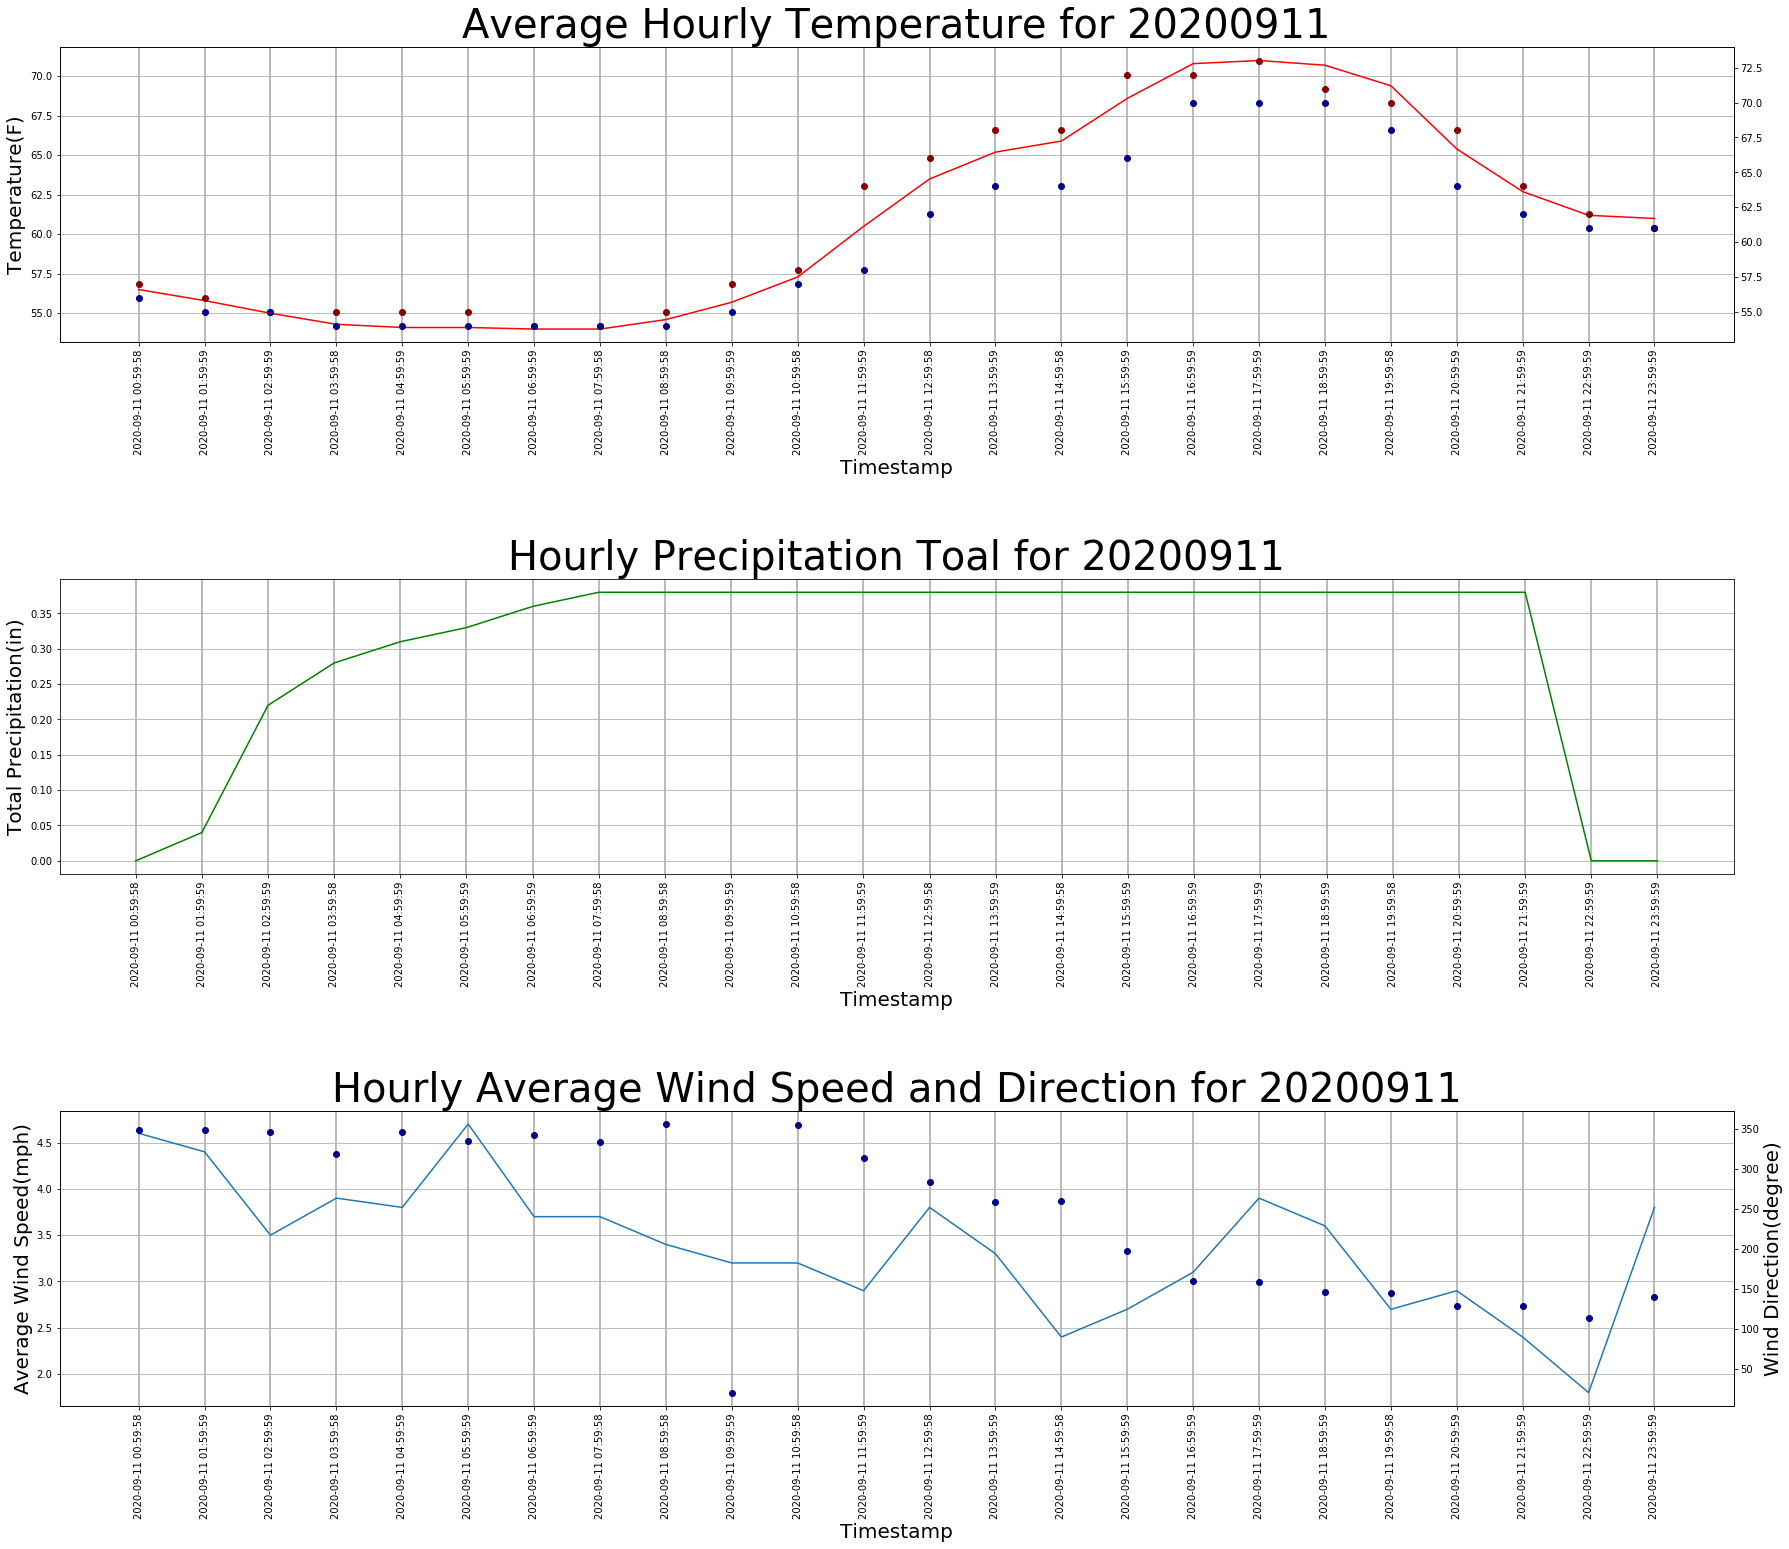